<a href="https://colab.research.google.com/github/anaguilarar/CC_Weight_Prediction/blob/main/1_Individual_plant_detection_YOLO_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chinese cabbage detection

In this example, we will explain how we can use YOLO to detect Chinese cabbage in the field. YOLO is a model that has been widely used for rapid crop detection. It is a deep learning model that suggests possible bounding boxes after dividing the image into a number of fixed size grids. Each region contains a confidence value, which represents the certainty that the model has in determining whether the bounding box contains an object or not. 

In [1]:
import os
## clonning repositories
if not os.path.exists("/content/drone_data") and not os.getcwd().endswith("/content/drone_data"):
    !git clone https://github.com/anaguilarar/drone_data.git
    print("Cloned")
    
else:
    print("drone_data directory already exists")


if not os.path.exists("/content/yolov5") and not os.getcwd().endswith("/content/yolov5"):
    !git clone https://github.com/ultralytics/yolov5.git
    print("Cloned")
    
else:
    print("yolov5 directory already exists")


Cloning into 'drone_data'...
remote: Enumerating objects: 1036, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 1036 (delta 22), reused 36 (delta 15), pack-reused 988
Receiving objects: 100% (1036/1036), 17.04 MiB | 13.49 MiB/s, done.
Resolving deltas: 100% (775/775), done.
Cloned
Cloning into 'yolov5'...
remote: Enumerating objects: 15692, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 15692 (delta 5), reused 14 (delta 4), pack-reused 15672
Receiving objects: 100% (15692/15692), 14.48 MiB | 16.58 MiB/s, done.
Resolving deltas: 100% (10746/10746), done.
Cloned


In [ ]:
## installing packages
!pip install -r requirements


### Data downloading

The data that we will use as an example is an orthomosaic image that was captured on 29th September. Besides of the orthomosaic image, we will also use vector files that describes the field boundaries spatial information . This data is storaged in a google drive folder. Thus, the information will be uploaded to the colab storage using the folowing cell.

In [2]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


spatial_boundaries = '1YjKEgdUJ5edicNMNbevox4rXPPosbPDp'
rgb_ortho = '1jQTOWdWUXtLJwlILDlBqKP7zUDwGySsd'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

for linktod in [spatial_boundaries, rgb_ortho]:

  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(linktod)}).GetList()

  for i, file in enumerate(sorted(file_list, key = lambda x: x['title']), start=1):
    print('Downloading {} file from GDrive ({}/{})'.format(file['title'], i, len(file_list)))
    file.GetContentFile(file['title'])
 

### Data selection

We divided the field in two, one half for training and one half for testing.

In [ ]:
from drone_data.utils import drone_data
from drone_data.utils.plt_functions import plot_multibands_fromxarray
from drone_data.utils import gis_functions as gf
from drone_data.utils.xr_functions import split_xarray_data
from drone_data.utils.data_processing import from_xarray_2_rgbimage, scaleminmax

from drone_data.utils.data_processing import find_date_instring

import geopandas as gpd


In [3]:
TRAININGBOUNDING = '/content/tanashi_field_trainingyolo.shp'
TP1IMAGEPATH = "/content/tana_cc_rgb_210927_transparent_mosaic_group1.tif"


### Single training image visualization

In [14]:
roi = gpd.read_file(TRAININGBOUNDING)
imgdate1 = TP1IMAGEPATH
fielddata  = drone_data.DroneData(imgdate1, multiband_image=True, bounds=roi)


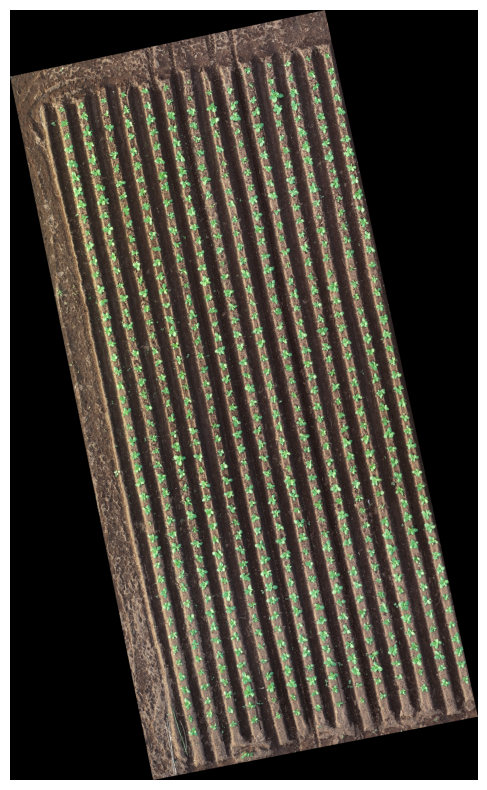

In [16]:
plot_multibands_fromxarray(fielddata.drone_data, bands = ['red', 'green', 'blue'], fig_sizex=10, fig_sizey=10, xinverse=False)

### Split into tiles

The second step was to divide each rgb image into tiles of sizes 512 x 512, this was done for making easier the labeling process.

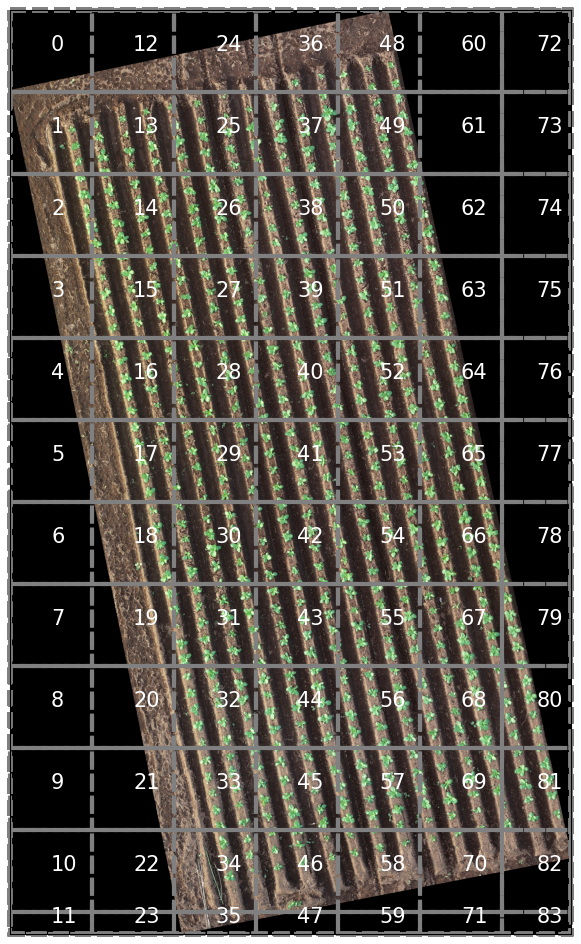

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle


threebanddata = []
for i in np.array(fielddata.drone_data.data_vars.variables):

    banddata = fielddata.drone_data[i].data
    banddata[banddata == fielddata.drone_data.attrs['nodata']] = np.nan
    threebanddata.append(scaleminmax(banddata))


fig,ax = plt.subplots(1, figsize=(8,12))

_, boxes = split_xarray_data(fielddata.drone_data, polygons = True,
                                width = 512, height = 512, overlap = 0)

arraypplot = np.array(threebanddata)

if(arraypplot.shape[0]==3):
    arraypplot  = np.moveaxis(arraypplot, 0, -1)


font = {'color':  'white',
        'weight': 'normal',
        'size': 15}

ax.imshow(arraypplot)

for i,box in boxes:
    if i % 1 == 0:
            
        xs, ys = box.exterior.xy 
        minx, miny, maxx, maxy =box.bounds
        width, height = abs(maxx - minx),  abs(miny-maxy)
        # Create a Rectangle patch
        rect = Rectangle( (minx,miny), width,height, linestyle = 'dashed', facecolor = 'None', 
                        clip_on=False,edgecolor='gray',lw=3)
        ax.add_patch(rect)
        #ax.fill(xs, ys, facecolor='none', color='--', linewidth=3)
        ax.text(xs[0] + (xs[2] - xs[0])/2,ys[0] + (ys[2] - ys[0])/2,str(i), fontdict=font)
        ax.set_xticks([])
        ax.set_yticks([])

    rect = Rectangle( (0,0), arraypplot.shape[1], arraypplot.shape[0], linestyle = 'dashed', facecolor = 'None', 
                        clip_on=False,edgecolor='gray',lw=3)
    ax.add_patch(rect)

the image was divided into 84 tiles


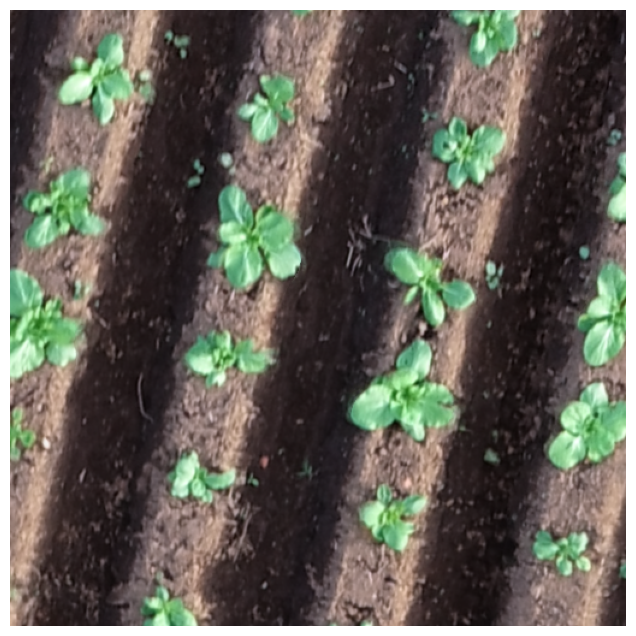

In [19]:
### Single tile example

fielddata.split_into_tiles(width = 512, height = 512, overlap = 0) 
tileid = 69
plot_multibands_fromxarray(fielddata.tiles_data(69), bands = ['red', 'green', 'blue'])

### Imagery export

The tiles information was exported as JPG an the it was uploaded into the Roboflow platform for manually drawing the boujnding boxes.

In [ ]:
#### export as raster file
fielddata.tiles_data(tileid).rio.to_raster(f'tile_{tileid}_tanashi_tp2.tif')

In [ ]:
## export individuals images as JPG

### export as png
outputfolder = "tr_images/awaji_2022_tiles_512/"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

for fimg in [imgdate1]:
    
    fielddata  = drone_data.DroneData(fimg, multiband_image=True, roi = roi)
    fielddata.split_into_tiles(width = 512, height = 512, overlap = 0) 
    
    date = find_date_instring(fimg)
    for i in range(0,len(fielddata._tiles_pols)):
        
        filename = os.path.join(outputfolder, "imgs_{}_tile_{}.jpg".format(date,i))
        data_tile = from_xarray_2_rgbimage(fielddata.tiles_data(i),
                                        export_as_jpg=True,
                                        ouputpath=filename)
        

the image was divided into 208 tiles


d:\OneDrive - Universidad Nacional de Colombia\PhD\dron_data\scripts\drone_data\utils\data_processing.py:145: RuntimeWarning: All-NaN slice encountered
  banddata = (banddata *255)/ np.nanmax(banddata)


### Roboflow

Once the tiles were exported as an image, they were uploaded into Roboflow. This is a user-friendly platform for manually drawing images to be used for training. The following steps will require you to download the imagery after being labeled using the following [link](https://universe.roboflow.com/andres-u8hev/tanashipaper/dataset/1). 


### Model's training

The images uploaded to roboflow belongs to the field denoted as training. But for intenal validation, we separate 15% of the data for validation.
 

In [ ]:

from drone_data.ImagesTransform.image_processing import ImageData
from drone_data.ImagesTransform.general_functions import get_ids_split_datasets


RAWIMAGESPATH = "tanashi_tiles_512_paper/tanashi_tiles_512_raw/yolo/"


imgs_data = ImageData(RAWIMAGESPATH, 
                      image_size = (10, 10))

100%|██████████| 152/152 [00:00<00:00, 301.79it/s]


In [ ]:
### 
val_percentage = 15
test_percentage = 0
ntotal = len(imgs_data.images_data['raw'])
idssplit = get_ids_split_datasets(ntotal, val_perc=val_percentage,test_perc=test_percentage)
outputfolder = "training_images/"
model_folder = ["training","validation","test"]

print(f"""Total training images: {len(idssplit[0])}
Total validation: {len(idssplit[1])}""")


Total training images: 130
Total validation: 22


#### Data augmentation

To augment the data that is gonnabe used for training, we applied 3 different algorithms that modified the images:
-   Rotation
-   Image zooming
-   Color change

In [ ]:
imgs_datatraining = ImageData(RAWIMAGESPATH,
                              id_image=20)

['tanashi_tiles_512_paper/tanashi_tiles_512_raw/yolo\\images\\imgs_20210929_tile_40_jpg.rf.5e45979cff3587895a1829df82683247.jpg']


100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


####  Export new images created with data augmentation


In [ ]:

## export training

imgs_datatraining = ImageData(RAWIMAGESPATH, 
                              id_image=list(idssplit[0]))

imgs_datatraining.aug_change_hsv(['raw'], hue_shift = list(range(-25,25,5)), sat_shift = list(range(-25,25,5)), val_shift = list(range(-25,25,5)))
imgs_datatraining.aug_rotate_image(['raw'], angle = list(range(-265,270,90)))
imgs_datatraining.aug_expand_image('rotate',samplesize = 60, ratio = list(range(-14,14,7)))


100%|██████████| 130/130 [00:20<00:00,  6.49it/s]


130 were added to images data
130 were added to images data
78 were added to images data


In [ ]:
fout = os.path.join(outputfolder,'training')
if not os.path.exists(fout):
    os.makedirs(fout)
imgs_datatraining.to_jpg(output_path=os.path.join(outputfolder,'training'), size= (512,512))

In [ ]:
## export validation 

imgs_datavalidation = ImageData(RAWIMAGESPATH, 
                              id_image=list(idssplit[1]))

imgs_datavalidation.aug_change_hsv(['raw'], hue_shift = list(range(-25,25,5)), sat_shift = list(range(-25,25,5)), val_shift = list(range(-25,25,5)))
imgs_datavalidation.aug_rotate_image(['raw'], angle = list(range(-270,270,90)))
imgs_datavalidation.aug_expand_image('rotate',samplesize = 60, ratio = [-5,-10,5,10])

100%|██████████| 22/22 [00:03<00:00,  6.05it/s]


22 were added to images data
22 were added to images data
13 were added to images data


imgs_20211004_tile_30_jpg.rf.62378f856788addc2f24eab8487c146f
imgs_20211004_tile_30_jpg.rf.62378f856788addc2f24eab8487c146f_hsv_15_0_-20
imgs_20211004_tile_30_jpg.rf.62378f856788addc2f24eab8487c146f_rotate_90
imgs_20210929_tile_13_jpg.rf.da4d6862b4e2c84b106427dfaa120702_rotate_-90_expand_-10


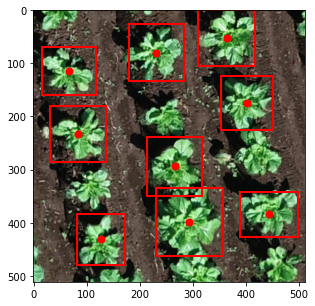

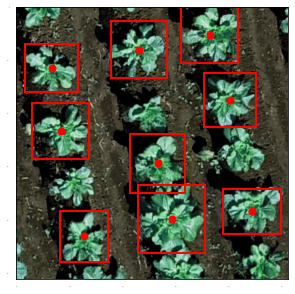

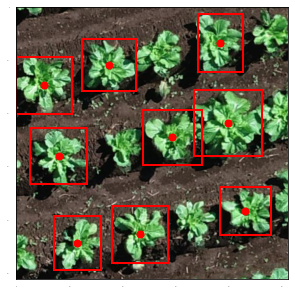

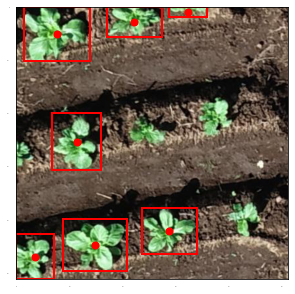

In [ ]:
iddata= 5
print(imgs_datavalidation.images_names['raw'][iddata])
print(imgs_datavalidation.images_names['hsv'][iddata])
print(imgs_datavalidation.images_names['rotate'][iddata])
print(imgs_datavalidation.images_names['expand'][iddata])
imgs_datavalidation.plot_image(iddata,sourcetype='raw', add_label=True, figsize=(5,5))
imgs_datavalidation.plot_image(iddata,sourcetype='hsv', add_label=True, figsize=(5,5))
imgs_datavalidation.plot_image(iddata,sourcetype='rotate', add_label=True, figsize=(5,5))
imgs_datavalidation.plot_image(iddata,sourcetype='expand', add_label=True, figsize=(5,5))

In [ ]:
fout = os.path.join(outputfolder,'validation')
if not os.path.exists(fout):
    os.makedirs(fout)
imgs_datavalidation.to_jpg(output_path=os.path.join(outputfolder,'validation'), size= (512,512))

In [ ]:
##### export yaml file: this file used for yolo training

trainingfolder = os.path.join(os.getcwd(),outputfolder, "training/images").replace('\\','/')
valfolder = os.path.join(os.getcwd(),outputfolder, "validation/images").replace('\\','/')
ncategories = 1
namecategori = ['chcabbage']

with open(os.path.join(outputfolder,"data.yaml"), 'w') as dst:
    dst.write("train: {}\nval: {}\n\nnc: {}\nnames: {}".format(
        trainingfolder,
        valfolder,
        ncategories,
        namecategori
    ))
    

In [ ]:
### read total training boundaing boxes

import os
import numpy as np
paths = 'training_images/merged/training/labels'
filestoread = os.listdir(paths)

totallines = []
for fn in range(len(filestoread)):
    with open(os.path.join(paths,filestoread[fn]), 'r') as fp:
        x = len(fp.readlines())
        totallines.append(x)
        #print('Total lines:', x) # 8

print("Total bounding boxes: {}".format(np.array(totallines).sum()))

Total bounding boxes: 6254


### YOLO training

Once was set up all the training dataset, next step is to train the model



In [ ]:
import torch
import os
dateset_path = "/training_images/merged/"
odpath = 'yolov5'"../drone_data/models/cc_tanashi_v2/weights/best.pt"

In [ ]:
!python yolov5\train.py --workers 1 --img 512 --batch 4 --epochs 300 --data training_images\merged\data.yaml --weights weigths\cc_uav_tanashi\best.pt --cache 

^C


train: weights=..\drone_data\model\cc_tanashi_v2\weights\best.pt, cfg=, data=training_images\merged\data.yaml, hyp=yolov5\data\hyps\hyp.scratch-low.yaml, epochs=300, batch_size=4, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=1, project=yolov5\runs\train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
From https://github.com/ultralytics/yolov5
   342fe05..443ef7f  master     -> origin/master
   c6323b2..d371b16  exp13      -> origin/exp13
github:  YOLOv5 is out of date by 1 commit. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
requirements: YOLOv5 requirement "thop>=0.1.1" not found, attempting AutoUpda

### Individual plant detection

Once that our image was uploaded, we will be able to upload yolo's model for detecting chinese cabbage

In [ ]:
## setting yolo model
import sys
import os 
sys.path.append(os.path.join(os.getcwd(), 'yolov5'))


In [ ]:

from yolov5.utils.torch_utils import select_device
from yolov5.models.common import DetectMultiBackend
## setting device
device = select_device()
## loading model

weights = "od_weights/best.pt"
#weights = "../drone_data/models/cc_tanashi_v2/weights/best.pt"
model = DetectMultiBackend(weights, device=device)

In [ ]:
from drone_data.utils.od_functions import DroneObjectDetection

In [ ]:
### reading data
import geopandas as gpd

roi = gpd.read_file('F:/OneDrive - The University of Tokyo/drone_data/sp_data/tanashi/tanashi_field.shp')
TP1IMAGEPATH = "F:/drone_data/Tanashi_cc_winter_2021/dc_3_20210929/P4rtk_15m_RTK/tana_cc_rgb_210929/3_dsm_ortho/2_mosaic/"


drdata = DroneObjectDetection(TP1IMAGEPATH, yolo_model= model, device = device, multiband_image=True, roi = roi)

torch.Size([1, 3, 512, 512])


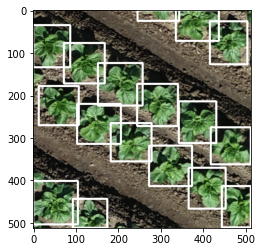

In [ ]:
import torch

idtile = 102

imgdraw = drdata.draw_bb_in_tile(drdata.tiles_data(idtile))

plt.imshow(imgdraw/255.)


In [ ]:
allpols = drdata.detect_oi_in_uavimage(imgsize = 512, overlap = [0,0.2,0.4], aoi_limit = 0.5, onlythesetiles = None, conf_thres=0.50)

the image was divided into 532 tiles
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
torch.Size([1, 3, 512, 512])
23
torch.Size([1, 3, 512, 512])
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
torch.Size([1, 3, 512, 512])
41
torch.Size([1, 3, 512, 512])
42
torch.Size([1, 3, 512, 512])
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
torch.Size([1, 3, 512, 512])
59
torch.Size([1, 3, 512, 512])
60
torch.Size([1, 3, 512, 512])
61
torch.Size([1, 3, 512, 512])
62
torch.Size([1, 3, 512, 512])
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
torch.Size([1, 3, 512, 512])
79
torch.Size([1, 3, 512, 512])
80
torch.Size([1, 3, 512, 512])
81
torch.Size([1, 3, 512, 512])
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
torch.Size([1, 3, 512, 512])
98
torch.Size([1, 3, 512, 512])
99
torch.Size([1, 3, 512, 512])
100
torch.Size([1, 3, 512, 512])
101
torch.Size([1, 3, 512, 512])
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
torch.Size([1, 3, 512, 512])
118
torch.Size([1, 3,